<a href="https://www.kaggle.com/code/rafifariqrabbani/alns-for-christmas-tree-packing?scriptVersionId=290052937" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Adaptive Large Neighborhood Search (ALNS) for Christmas Tree Packing Optimization

Adaptive Large Neighborhood Search (ALNS) is a metaheuristic optimization algorithm that extends the classic Large Neighborhood Search (LNS) framework by incorporating adaptive selection mechanisms for its operators.

Key Characteristics:
1. Destruction and Repair Framework: ALNS works by iteratively destroying part of a current solution and then repairing it to create a new solution
2. Adaptive Operator Selection: The algorithm dynamically adjusts which "destroy" and "repair" operators to use based on their historical performance
3. Acceptance Criterion: Uses simulated annealing or similar mechanisms to decide whether to accept worse solutions (to escape local optima)
4. Problem-Agnostic: Can be applied to various combinatorial optimization problems with appropriate operator design

Adaptive Large Neighborhood Search (ALNS) operates as a heuristic optimization method, meaning it does not guarantee mathematically optimal solutions. Instead, it seeks to find near optimal solutions that are often sufficient for practical applications. ALNS demonstrates particular strength in solving non-identical item arrangement and packing problems, where items vary in shape, size, orientation, or other attributes. This contrasts with identical-item packing problems that often have more straightforward optimal solutions

This code installs the Shapely geometry library and imports essential Python packages for mathematical computations, data handling, geometric operations, optimization algorithms, and visualization. These imports collectively enable the implementation and analysis of an ALNS algorithm for solving complex spatial arrangement problems like the Christmas tree packing problem.

In [2]:
!pip install shapely
import numpy as np
import pandas as pd
import random
import math
import time
from decimal import Decimal
from shapely import affinity
from shapely.geometry import Polygon
from shapely.strtree import STRtree
from sklearn.cluster import KMeans
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
os.environ['OMP_NUM_THREADS'] = '1'

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

This code defines a ChristmasTree class that creates a geometric polygon representation of a Christmas tree with configurable position and rotation, using precise decimal coordinates and the Shapely library for spatial transformations.

In [3]:
# ===========================================================================================
# CHRISTMAS TREE CLASS
# ===========================================================================================

class ChristmasTree:
    """Represents a single, rotatable Christmas tree"""
    
    # Counter unique id
    _id_counter = 0
    
    def __init__(self, center_x='0', center_y='0', angle='0', tree_id=None):
        # Assign unique id
        if tree_id is None:
            ChristmasTree._id_counter += 1
            self.id = ChristmasTree._id_counter
        else:
            self.id = tree_id
            
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)
        
        # Tree dimensions 
        trunk_w = 0.15
        trunk_h = 0.2
        base_w = 0.7
        mid_w = 0.4
        top_w = 0.25
        tip_y = 0.8
        tier_1_y = 0.5
        tier_2_y = 0.25
        base_y = 0.0
        trunk_bottom_y = -trunk_h
        
        
        initial_polygon = Polygon([
            (0.0, tip_y),
            (top_w / 2, tier_1_y),
            (top_w / 4, tier_1_y),
            (mid_w / 2, tier_2_y),
            (mid_w / 4, tier_2_y),
            (base_w / 2, base_y),
            (trunk_w / 2, base_y),
            (trunk_w / 2, trunk_bottom_y),
            (-(trunk_w / 2), trunk_bottom_y),
            (-(trunk_w / 2), base_y),
            (-(base_w / 2), base_y),
            (-(mid_w / 4), tier_2_y),
            (-(mid_w / 2), tier_2_y),
            (-(top_w / 4), tier_1_y),
            (-(top_w / 2), tier_1_y),
        ])
        
        # Rotation & translation
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated,
            xoff=float(self.center_x),
            yoff=float(self.center_y)
        )

This section contains the core helper functions for the ALNS algorithm: get_score() calculates packing density, has_overlap_fast() efficiently detects tree intersections, generate_initial_solution() creates starting arrangements, post_optimize_all_rotations() refines solutions with smart optimization techniques, and adaptive_weight_update() dynamically adjusts operator selection throughout the search process.

In [4]:
# ===========================================================================================
# CORE HELPER FUNCTIONS
# ===========================================================================================
def get_score(trees):
    """Calculate score = s²/n where s is side of bounding box"""
    if not trees:
        return 0.0
    
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T for t in trees])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    side = max(max_x - min_x, max_y - min_y)
    score = side ** 2 / len(trees)
    return float(score)


def has_overlap_fast(trees):
    """Fast overlap check for small n, STRtree for large n"""
    if not trees:
        return False
    
    n = len(trees)
    
    if n <= 20:
        for i in range(n):
            for j in range(i + 1, n):
                if trees[i].polygon.intersects(trees[j].polygon):
                    if not trees[i].polygon.touches(trees[j].polygon):
                        return True
        return False
    
    polygons = [t.polygon for t in trees]
    tree_index = STRtree(polygons)
    
    for i, poly in enumerate(polygons):
        indices = tree_index.query(poly)
        for idx in indices:
            if idx == i:
                continue
            if poly.intersects(polygons[idx]) and not poly.touches(polygons[idx]):
                return True
    return False


def is_position_available(solution, x, y, tolerance=1e-6):
    """Check if position (x,y) is already occupied"""
    for tree in solution:
        if abs(float(tree.center_x) - x) < tolerance and abs(float(tree.center_y) - y) < tolerance:
            return False
    return True


def optimize_rotation_scipy(solution, x, y):
    """Find optimal rotation angle using scipy optimization"""
    if not solution:
        return 0.0
    
    def objective(angle_deg):
        """Calculate bounding box side length for given angle"""
        test_tree = ChristmasTree(str(x), str(y), str(angle_deg))
        test_solution = solution + [test_tree]
        
        if has_overlap_fast(test_solution):
            return 1e9
        
        xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T 
                              for t in test_solution])
        min_x, min_y = xys.min(axis=0)
        max_x, max_y = xys.max(axis=0)
        return max(max_x - min_x, max_y - min_y)
    
    res = minimize_scalar(objective, bounds=(0, 360), method='bounded')
    return res.x if res.fun < 1e9 else 0.0


# ===========================================================================================
# INITIAL SOLUTION GENERATION
# ===========================================================================================
def generate_initial_solution(n_trees):
    solution = []
    
    TREE_MAX_DIAGONAL = 1.3
    spacing = TREE_MAX_DIAGONAL * 0.95
    
    grid_size = int(math.ceil(math.sqrt(n_trees)))
    
    for i in range(n_trees):
        row = i // grid_size
        col = i % grid_size
        x = col * spacing - (grid_size * spacing) / 2
        y = row * spacing - (grid_size * spacing) / 2
        
        best_angle = 0
        best_area = float('inf')
        
        for test_angle in [0, 45, 90, 135, 180, 225, 270, 315]:
            test_tree = ChristmasTree(str(x), str(y), str(test_angle))
            temp_sol = solution + [test_tree]
            
            xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T for t in temp_sol])
            min_x, min_y = xys.min(axis=0)
            max_x, max_y = xys.max(axis=0)
            area = (max_x - min_x) * (max_y - min_y)
            
            if area < best_area and not has_overlap_fast(temp_sol):
                best_area = area
                best_angle = test_angle
        
        tree = ChristmasTree(str(x), str(y), str(best_angle))
        solution.append(tree)
    
    if has_overlap_fast(solution):
        print("Warning: Overlap detected, expanding slightly...")
        for tree in solution:
            tree.center_x *= Decimal('1.1')
            tree.center_y *= Decimal('1.1')
            tree.__init__(str(tree.center_x), str(tree.center_y), str(tree.angle))
    
    print(f"Initial solution score: {get_score(solution):.6f}")
    return solution


# ===========================================================================================
# POST-OPTIMIZATION FUNCTIONS
# ===========================================================================================
def post_optimize_all_rotations(solution, max_iter=50):
    """Post-optimization: Optimize rotation of all trees after ALNS"""
    print(f"   Optimizing {len(solution)} trees...")
    best_score = get_score(solution)
    
    for iteration in range(max_iter):
        improved = False
        
        for i in range(len(solution)):
            original_x = solution[i].center_x
            original_y = solution[i].center_y
            
            temp_solution = solution[:i] + solution[i+1:]
            
            x = float(original_x)
            y = float(original_y)
            
            best_angle = optimize_rotation_scipy(temp_solution, x, y)
            new_tree = ChristmasTree(str(original_x), str(original_y), str(best_angle))
            test_solution = solution[:i] + [new_tree] + solution[i+1:]
            
            if not has_overlap_fast(test_solution):
                new_score = get_score(test_solution)
                if new_score < best_score - 1e-9:
                    best_score = new_score
                    improved = True
                    solution[i] = new_tree
        
        if not improved:
            print(f"   Converged after {iteration+1} iterations")
            break
    
    return solution



# ===========================================================================================
# ADAPTIVE WEIGHT UPDATE
# ===========================================================================================
def adaptive_weight_update(weights, selected_idx, code, iteration, max_iter, beta=0.8):
    """Update weight for selected operator"""
    progress = iteration / max_iter
    
    if progress < 0.3:
        rewards = {1: 2.5, 2: 1.5, 3: 0.3, 4: 0.0}
    elif progress < 0.7:
        rewards = {1: 2.0, 2: 1.2, 3: 0.2, 4: 0.0}
    else:
        rewards = {1: 1.8, 2: 1.0, 3: 0.1, 4: 0.0}
    
    reward = rewards[code]
    adaptive_beta = beta + (1 - beta) * progress
    
    for i in range(len(weights)):
        if i == selected_idx:
            weights[i] = adaptive_beta * weights[i] + (1 - adaptive_beta) * reward
        else:
            weights[i] = adaptive_beta * weights[i]
    
    weights = np.maximum(weights, 0.01)
    weights = weights / weights.sum()
    
    if weights.min() < 0.05:
        boost_factor = 0.05 * (1 - progress)
        weights += boost_factor
        weights = weights / weights.sum()
    
    return weights

This section implements the destroy and repair operators for the ALNS algorithm, with four destroy operators that efficiently remove trees using random destroy, spatial clustering, bounding box contribution analysis, and density-based sampling, and four repair operators that reconstruct solutions using random placement, greedy tessellation patterns, compact arrangement variants, and zone-based insertion strategies with strict angle preferences for optimal packing density.

In [5]:
# ===========================================================================================
# DESTROY OPERATORS
# ===========================================================================================
def destroy_random_fast(solution, rho):
    """D1: Ultra-fast random removal"""
    n = len(solution)
    k = max(1, int(n * rho))
    removed_indices = set(random.sample(range(n), min(k, n)))
    remaining = [solution[i] for i in range(n) if i not in removed_indices]
    removed = [solution[i] for i in removed_indices]
    return remaining, removed


def destroy_worst_bbox_contribution_fast(solution, rho):
    """D2: Fast bbox removal with randomness"""
    n = len(solution)
    k = max(1, int(n * rho))
    
    if n <= 5:
        return destroy_random_fast(solution, rho)
    
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T for t in solution])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    
    edge_indices = []
    eps = 0.01
    for i, tree in enumerate(solution):
        tree_bounds = np.asarray(tree.polygon.exterior.xy).T
        tree_min_x, tree_min_y = tree_bounds.min(axis=0)
        tree_max_x, tree_max_y = tree_bounds.max(axis=0)
        
        if (abs(tree_min_x - min_x) < eps or abs(tree_max_x - max_x) < eps or
            abs(tree_min_y - min_y) < eps or abs(tree_max_y - max_y) < eps):
            edge_indices.append(i)
    
    if not edge_indices:
        return destroy_random_fast(solution, rho)
    
    k_edge = max(1, int(k * 0.5))
    k_random = k - k_edge
    
    removed_count = min(k_edge, len(edge_indices))
    removed_indices = set(random.sample(edge_indices, removed_count))
    
    interior_indices = [i for i in range(n) if i not in edge_indices]
    if interior_indices and k_random > 0:
        random_count = min(k_random, len(interior_indices))
        removed_indices.update(random.sample(interior_indices, random_count))
    
    remaining = [solution[i] for i in range(n) if i not in removed_indices]
    removed = [solution[i] for i in removed_indices]
    return remaining, removed


def destroy_spatial_cluster_fast(solution, rho):
    """D3: Fast spatial cluster with adaptive sampling"""
    n = len(solution)
    k = max(1, int(n * rho))
    
    if n <= 5:
        return destroy_random_fast(solution, rho)
    
    if n <= 20:
        sample_size = n
    elif n <= 50:
        sample_size = max(10, int(n * 0.15))
    else:
        sample_size = max(20, int(n * 0.08))
    
    sampled_indices = random.sample(range(n), sample_size)
    
    coords = np.array([[float(t.center_x), float(t.center_y)] for t in solution])
    sampled_coords = coords[sampled_indices]
    
    densities = []
    for i, idx in enumerate(sampled_indices):
        dists = np.sqrt(((coords - sampled_coords[i])**2).sum(axis=1))
        avg_dist = np.partition(dists[dists > 0], min(3, len(dists)-1))[:min(3, len(dists)-1)].mean()
        densities.append((avg_dist, idx))
    
    densities.sort(reverse=True)
    seed_idx = densities[0][1] if densities else random.randint(0, n-1)
    
    seed_x, seed_y = float(solution[seed_idx].center_x), float(solution[seed_idx].center_y)
    
    distances = [(math.sqrt((float(t.center_x)-seed_x)**2 + (float(t.center_y)-seed_y)**2), i) 
                 for i, t in enumerate(solution)]
    distances.sort()
    
    k_nearest = int(k * 0.6)
    k_random = k - k_nearest
    
    removed_indices = {idx for _, idx in distances[:k_nearest]}
    
    if k_random > 0 and len(distances) > k_nearest + 5:
        middle_range = distances[k_nearest:min(len(distances), k_nearest + 20)]
        random_count = min(k_random, len(middle_range))
        removed_indices.update(idx for _, idx in random.sample(middle_range, random_count))
    
    remaining = [solution[i] for i in range(n) if i not in removed_indices]
    removed = [solution[i] for i in removed_indices]
    return remaining, removed


def destroy_worst_density(solution, rho):
    """D4: Remove low-density regions"""
    n = len(solution)
    k_remove = max(1, int(n * rho))
    
    if n <= 3:
        return destroy_random_fast(solution, rho)
    
    coords = np.array([[float(t.center_x), float(t.center_y)] for t in solution])
    
    densities = []
    k_neighbors = min(3, n - 1)
    
    for i in range(n):
        dists = np.sqrt(((coords - coords[i])**2).sum(axis=1))
        dists[i] = np.inf
        
        nearest = np.partition(dists, k_neighbors)[:k_neighbors]
        avg_dist = nearest.mean()
        
        density = 1.0 / (avg_dist + 0.01)
        densities.append((density, i))
    
    densities.sort()
    removed_indices = {idx for _, idx in densities[:k_remove]}
    
    remaining = [solution[i] for i in range(n) if i not in removed_indices]
    removed = [solution[i] for i in removed_indices]
    
    return remaining, removed


# ===========================================================================================
# REPAIR OPERATORS
# ===========================================================================================
def repair_random_fast(partial_solution, removed_trees):
    """R1: Fast random with compact bias"""
    solution = partial_solution.copy()
    
    if not solution:
        grid_size = int(math.ceil(math.sqrt(len(removed_trees))))
        spacing = 0.85
        
        for i, tree in enumerate(removed_trees):
            row, col = i // grid_size, i % grid_size
            x = col * spacing - (grid_size * spacing) / 2
            y = row * spacing - (grid_size * spacing) / 2
            solution.append(ChristmasTree(str(x), str(y), '0'))
        return solution
    
    cx = sum(float(t.center_x) for t in solution) / len(solution)
    cy = sum(float(t.center_y) for t in solution) / len(solution)
    
    for tree in removed_trees:
        placed = False
        
        for radius in [0.2, 0.4, 0.7, 1.0]:
            for _ in range(6):
                angle = random.uniform(0, 2 * math.pi)
                x = cx + radius * math.cos(angle)
                y = cy + radius * math.sin(angle)
                tree_angle = random.choice([0, 90, 180, 270])
                
                test_tree = ChristmasTree(str(x), str(y), str(tree_angle))
                test_solution = solution + [test_tree]
                
                if not has_overlap_fast(test_solution):
                    solution.append(test_tree)
                    placed = True
                    break
            if placed:
                break
        
        if not placed:
            for r in [1.5, 2.0, 2.5]:
                angle = random.uniform(0, 2*math.pi)
                x, y = cx + r*math.cos(angle), cy + r*math.sin(angle)
                test_tree = ChristmasTree(str(x), str(y), '0')
                if not has_overlap_fast(solution + [test_tree]):
                    solution.append(test_tree)
                    break
    
    return solution


def repair_greedy_fast(partial_solution, removed_trees, phase='balanced'):
    """R2: Fast greedy with reduced angle search"""
    solution = partial_solution.copy()
    
    if not solution:
        return repair_random_fast(partial_solution, removed_trees)
    
    n_trees = len(solution)
    cx = sum(float(t.center_x) for t in solution) / n_trees
    cy = sum(float(t.center_y) for t in solution) / n_trees
    
    if phase == 'explore':
        angles = [0, 45, 90, 135]
        n_compact = 12
        n_sparse = 6
    elif phase == 'exploit':
        angles = [0, 30, 60, 90, 120, 150]
        n_compact = 10
        n_sparse = 4
    else:
        angles = [0, 60, 120, 180]
        n_compact = 12
        n_sparse = 5
    
    for tree in removed_trees:
        best_config = None
        best_score = float('inf')
        current_score = get_score(solution)
        
        for _ in range(n_compact):
            r = random.uniform(0.15, 0.8)
            a = random.uniform(0, 2*math.pi)
            x, y = cx + r*math.cos(a), cy + r*math.sin(a)
            
            for ang in angles:
                test_tree = ChristmasTree(str(x), str(y), str(ang))
                test_solution = solution + [test_tree]
                
                if has_overlap_fast(test_solution):
                    continue
                    
                score = get_score(test_solution)
                if score < best_score:
                    best_score = score
                    best_config = test_tree
        
        if best_config is None or best_score > current_score + 0.1:
            for _ in range(n_sparse):
                r = random.uniform(0.8, 1.5)
                a = random.uniform(0, 2*math.pi)
                x, y = cx + r*math.cos(a), cy + r*math.sin(a)
                
                for ang in [0, 90, 180, 270]:
                    test_tree = ChristmasTree(str(x), str(y), str(ang))
                    test_solution = solution + [test_tree]
                    
                    if has_overlap_fast(test_solution):
                        continue
                        
                    score = get_score(test_solution)
                    if score < best_score:
                        best_score = score
                        best_config = test_tree
        
        if best_config:
            solution.append(best_config)
        else:
            for _ in range(3):
                r = random.uniform(1.5, 2.5)
                a = random.uniform(0, 2*math.pi)
                x, y = cx + r*math.cos(a), cy + r*math.sin(a)
                test_tree = ChristmasTree(str(x), str(y), '0')
                if not has_overlap_fast(solution + [test_tree]):
                    solution.append(test_tree)
                    break
    
    return solution


def repair_compact_smart(partial_solution, removed_trees):
    """R3: Simplified compact repair"""
    solution = partial_solution.copy()
    
    if not solution:
        return repair_random_fast(partial_solution, removed_trees)
    
    cx = sum(float(t.center_x) for t in solution) / len(solution)
    cy = sum(float(t.center_y) for t in solution) / len(solution)
    
    fixed_angles = [0, 90, 180, 270]
    
    for idx, tree in enumerate(removed_trees):
        n_radii = 4
        radii = np.linspace(0.2, 0.8, n_radii)
        
        best_config = None
        best_score = float('inf')
        
        for radius in radii:
            n_positions = 6 if radius < 0.5 else 4
            for pos in range(n_positions):
                angle_rad = pos * (2*math.pi / n_positions)
                x = cx + radius * math.cos(angle_rad)
                y = cy + radius * math.sin(angle_rad)
                
                for tree_angle in fixed_angles:
                    test_tree = ChristmasTree(str(x), str(y), str(tree_angle))
                    test_solution = solution + [test_tree]
                    
                    if not has_overlap_fast(test_solution):
                        score = get_score(test_solution)
                        if score < best_score:
                            best_score = score
                            best_config = test_tree
        
        if best_config:
            solution.append(best_config)
        else:
            for _ in range(2):
                r = random.uniform(1.0, 1.8)
                a = random.uniform(0, 2*math.pi)
                x, y = cx + r*math.cos(a), cy + r*math.sin(a)
                test_tree = ChristmasTree(str(x), str(y), '0')
                if not has_overlap_fast(solution + [test_tree]):
                    solution.append(test_tree)
                    break
    
    return solution


def repair_zone_insertion(partial_solution, removed_trees):
    """R4: Smart zone-based repair"""
    solution = partial_solution.copy()
    
    if not solution or len(removed_trees) == 0:
        return repair_random_fast(partial_solution, removed_trees)
    
    cx = sum(float(t.center_x) for t in solution) / len(solution)
    cy = sum(float(t.center_y) for t in solution) / len(solution)
    
    if len(solution) > 1:
        coords = np.array([[float(t.center_x), float(t.center_y)] for t in solution])
        dists = np.sqrt(((coords - [cx, cy])**2).sum(axis=1))
        avg_radius = dists.mean()
        max_radius = dists.max()
        
        start_radius = max(0.1, avg_radius * 0.6)
        end_radius = max_radius * 1.2
    else:
        start_radius = 0.1
        end_radius = 2.0
    
    for tree in removed_trees:
        placed = False
        n_steps = max(8, min(15, int((end_radius - start_radius) / 0.12)))
        
        for radius in np.linspace(start_radius, end_radius, n_steps):
            n_attempts = 6 if radius < 0.6 else 4
            
            if radius < 0.6:
                angles = [0, 60, 120, 180, 240, 300]
            elif radius < 1.2:
                angles = [0, 45, 90, 135, 180, 225, 270, 315]
            else:
                angles = [0, 90, 180, 270]
            
            for _ in range(n_attempts):
                angle_pos = random.uniform(0, 2 * math.pi)
                x = cx + radius * math.cos(angle_pos)
                y = cy + radius * math.sin(angle_pos)
                
                for ang in angles:
                    new_tree = ChristmasTree(str(x), str(y), str(ang))
                    test_solution = solution + [new_tree]
                    
                    if not has_overlap_fast(test_solution):
                        solution.append(new_tree)
                        placed = True
                        break
                
                if placed:
                    break
            
            if placed:
                break
        
        if not placed:
            for r in [end_radius, end_radius * 1.3]:
                angle = random.uniform(0, 2*math.pi)
                x, y = cx + r*math.cos(angle), cy + r*math.sin(angle)

                for ang in [0, 90, 180, 270]:
                    test_tree = ChristmasTree(str(x), str(y), str(ang))
                    if not has_overlap_fast(solution + [test_tree]):
                        solution.append(test_tree)
                        break
                if len(solution) > len(partial_solution):
                    break
    
    return solution

The run_alns() function implements the complete Adaptive Large Neighborhood Search algorithm with simulated annealing that iteratively applies destroy and repair operators, adaptively adjusts operator weights based on performance, and includes post-optimization refinement to solve the Christmas tree packing problem within specified time limits.

In [6]:
def run_alns(n_trees, random_seed=None, max_time_minutes=2.0):
    """
    ALNS with:
    1. Reduced computational cost
    2. Dynamic adaptive mechanism
    3. Time-based termination
    """
    
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
    
    print(f"\n{'='*80}")
    print(f"ALNS OPTIMIZED v2.0 - Christmas Tree Packing (n={n_trees})")
    print(f"{'='*80}")
    
    #OPTIMIZED PARAMETERS
    T_init = 100000
    T_final = 0.01
    alpha = 0.97
    DoD = [0.2, 0.4]
    max_iter_estimate = int(math.log(T_final / T_init) / math.log(alpha))
    
    print(f"\n Optimized Parameters v2:")
    print(f"   T_init: {T_init}, T_final: {T_final}, alpha: {alpha}")
    print(f"   Estimated max iterations: {max_iter_estimate}") 
    print(f"   DoD: {DoD}, Time limit: {max_time_minutes}min")
    
    # Generate initial solution
    current_solution = generate_initial_solution(n_trees)
    current_score = get_score(current_solution)
    best_solution = current_solution.copy()
    best_score = current_score
    
    print(f"Initial score: {current_score:.6f}")
    
    # Operators - FAST VERSION
    destroy_ops = [
        destroy_random_fast,
        destroy_worst_bbox_contribution_fast,
        destroy_spatial_cluster_fast,
        destroy_worst_density
    ]
    
    repair_ops = [
        repair_random_fast,
        repair_greedy_fast, 
        repair_compact_smart,
        repair_zone_insertion
    ]
    
    # Weights
    Destroy_Weight = np.ones(4) / 4
    Repair_Weight = np.ones(4) / 4
    
    # Statistics
    n_accepted = 0
    n_better = 0
    n_iterations = 0
    T = T_init
    
    start_time = time.time()
    max_time_seconds = max_time_minutes * 60
    
    # Header
    print(f"\n{'Iter':<6} {'T':<10} {'Current':<10} {'Best':<10} {'Time(s)':<8} | "
          f"{'D1':<6} {'D2':<6} {'D3':<6} {'D4':<6} | "
          f"{'R1':<6} {'R2':<6} {'R3':<6} {'R4':<6}")
    print("-" * 100)
    
    while T > T_final and (time.time() - start_time) < max_time_seconds:
        temp_progress = (T_init - T) / (T_init - T_final)
        rho = DoD[1] - (DoD[1] - DoD[0]) * temp_progress
        
        #DETERMINE PHASE
        if temp_progress < 0.3:
            phase = 'explore'
        elif temp_progress < 0.7:
            phase = 'balanced'
        else:
            phase = 'exploit'
        
        # Select operators
        destroy_probs = Destroy_Weight / Destroy_Weight.sum()
        destroy_idx = np.random.choice(4, p=destroy_probs)
        
        repair_probs = Repair_Weight / Repair_Weight.sum()
        repair_idx = np.random.choice(4, p=repair_probs)
        
        # Apply destroy
        partial_solution, removed_trees = destroy_ops[destroy_idx](current_solution, rho)
        
        #Apply repair WITH PHASE for greedy
        if repair_idx == 1:  # repair_greedy_fast
            new_solution = repair_greedy_fast(partial_solution, removed_trees, phase)
        else:
            new_solution = repair_ops[repair_idx](partial_solution, removed_trees)

        #EVALUATE WITH VALIDATION (INSIDE WHILE LOOP - 8 SPACES!)
        if len(new_solution) != n_trees:
            code = 4
            new_score = float('inf')
        elif has_overlap_fast(new_solution):
            code = 4
            new_score = float('inf')
        else:
            new_score = get_score(new_solution)
            delta = new_score - current_score

            if delta < -1e-9:
                current_solution = new_solution
                current_score = new_score
                code = 1
                n_accepted += 1
                n_better += 1

                if new_score < best_score - 1e-9:
                    best_solution = new_solution.copy()
                    best_score = new_score
            elif random.random() < math.exp(-delta / T):
                current_solution = new_solution
                current_score = new_score
                code = 2
                n_accepted += 1
            else:
                code = 3
        
        Destroy_Weight = adaptive_weight_update(
            Destroy_Weight, 
            destroy_idx,  
            code,         
            n_iterations, 
            max_iter_estimate
        )

        Repair_Weight = adaptive_weight_update(
            Repair_Weight, 
            repair_idx,  
            code,         
            n_iterations, 
            max_iter_estimate
        )
        n_iterations += 1
        T *= alpha
        
        # Print progress
        if n_iterations % 10 == 0:
            elapsed = time.time() - start_time
            print(f"{n_iterations:<6} {T:<10.1e} {current_score:<10.4f} {best_score:<10.4f} {elapsed:<8.1f} | "
                  f"{Destroy_Weight[0]:<6.2f} {Destroy_Weight[1]:<6.2f} {Destroy_Weight[2]:<6.2f} {Destroy_Weight[3]:<6.2f} | "
                  f"{Repair_Weight[0]:<6.2f} {Repair_Weight[1]:<6.2f} {Repair_Weight[2]:<6.2f} {Repair_Weight[3]:<6.2f}")
    
    elapsed = time.time() - start_time
    
    print(f"\n{'='*80}")
    print(f" COMPLETED in {elapsed:.2f}s ({n_iterations} iterations)")
    print(f"   Acceptance rate: {(n_accepted/n_iterations)*100:.1f}%")
    print(f"   Better solutions: {n_better}")
    
    # Post-optimization
    print(f"\n Post-optimizing...")
    best_solution = post_optimize_all_rotations(best_solution, max_iter=30)
    best_score = get_score(best_solution)
    
    print(f"\n{'='*60}")
    print(f"AFTER POST-OPTIMIZATION:")
    print(f"   Trees: {len(best_solution)}")
    print(f"   Score: {best_score:.6f}")
    print(f"   Has overlap: {has_overlap_fast(best_solution)}")
    for i, t in enumerate(best_solution):
        print(f"   Tree {i}: x={float(t.center_x):.3f}, y={float(t.center_y):.3f}, angle={t.angle}")
    print(f"{'='*60}\n")
    
    print(f"After optimization: {best_score:.6f}")
    print(f"{'='*80}")
    
    return best_solution, best_score, {'time': elapsed, 'iterations': n_iterations}

The load_solution() function reads and parses Christmas tree arrangements from CSV files, while plot_alns_results() and plot_alns_comparison() create visualizations of tree placements and bounding boxes; the main execution section then loads existing solutions, runs the ALNS algorithm for specified tree counts, displays performance summaries, and optionally generates comparison plots showing initial versus optimized arrangements.


CHRISTMAS TREE PACKING ALNS
Running for n = [30]

📂 Loading CSV file...
✅ Loaded 200 different n values from /kaggle/input/santa-2025/sample_submission.csv

🚀 Running ALNS for n = [30]


################################################################################
SOLVING FOR n = 30 TREES
################################################################################

Initial solution score: 1.575521

ALNS OPTIMIZED v2.0 - Christmas Tree Packing (n=30)

 Optimized Parameters v2:
   T_init: 100000, T_final: 0.01, alpha: 0.97
   Estimated max iterations: 529
   DoD: [0.2, 0.4], Time limit: 2.0min
Initial solution score: 1.575521
Initial score: 1.575521

Iter   T          Current    Best       Time(s)  | D1     D2     D3     D4     | R1     R2     R3     R4    
----------------------------------------------------------------------------------------------------
10     7.4e+04    1.0310     1.0036     7.5      | 0.64   0.11   0.18   0.07   | 0.07   0.07   0.07   0.78  
20     5.4e+04  

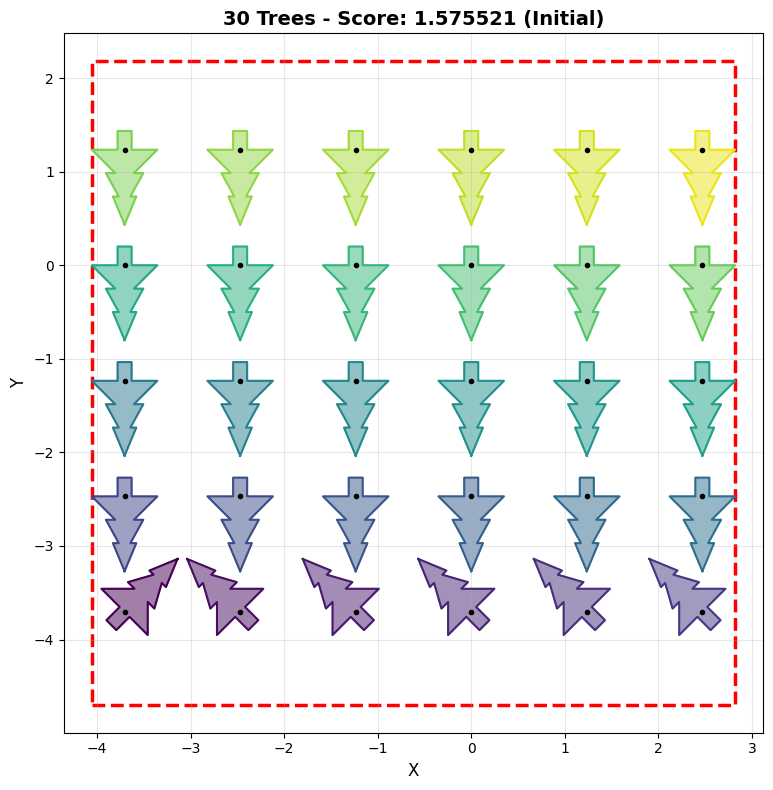

   → Final solution


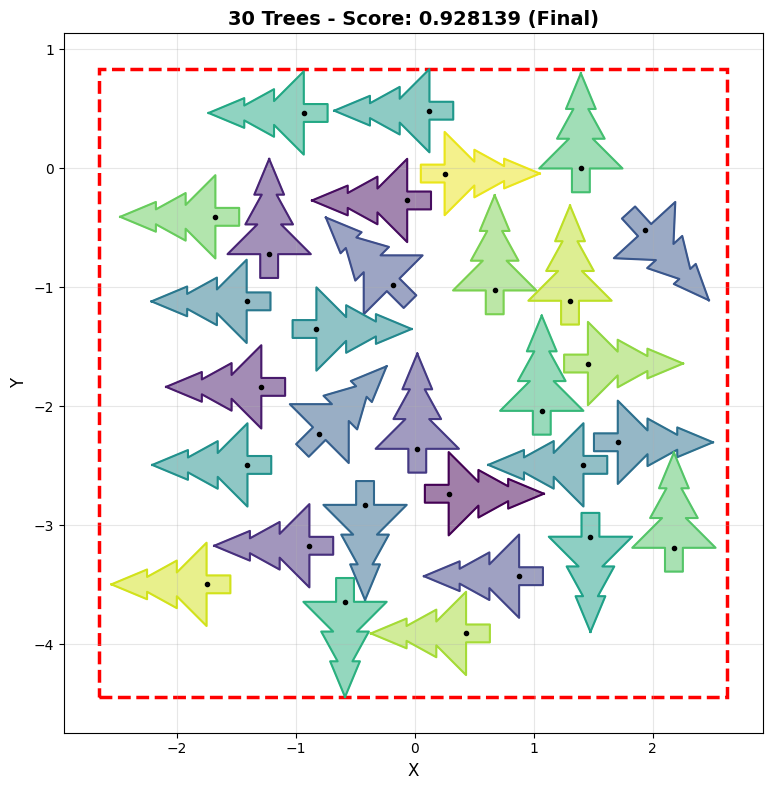

   → Comparison


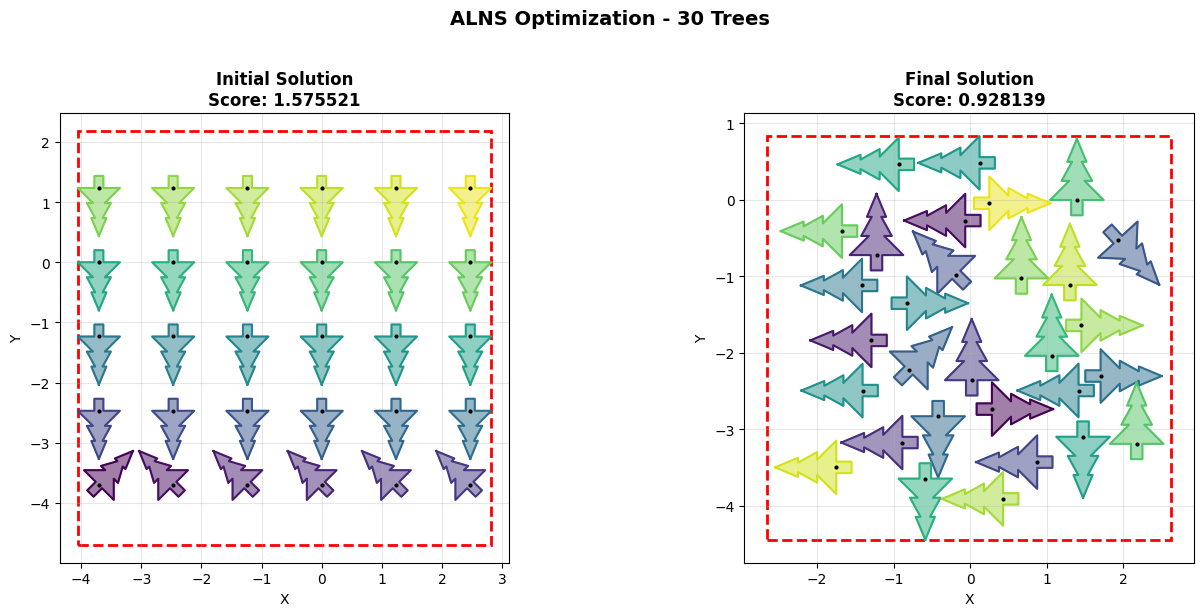


✅ All visualizations complete!



In [7]:
# ===========================================================================================
# LOAD SOLUTION FROM CSV (PREPROCESSING)
# ===========================================================================================
def load_solution(filename):
    """
    Load existing solution from CSV
    
    Returns:
        dict: {n: [list of ChristmasTree objects]}
    """
    df = pd.read_csv(filename)
    
    trees_by_n = {}
    
    for _, row in df.iterrows():
        # Parse id: "003_1" -> n=3, index=1
        n_str, idx_str = row['id'].split('_')
        n = int(n_str)
        
        # Parse coordinates: "s0.202736" -> "0.202736"
        x = row['x'].replace('s', '')
        y = row['y'].replace('s', '')
        deg = row['deg'].replace('s', '')
        
        if n not in trees_by_n:
            trees_by_n[n] = []
        
        tree = ChristmasTree(x, y, deg)
        trees_by_n[n].append(tree)
    
    print(f"✅ Loaded {len(trees_by_n)} different n values from {filename}")
    return trees_by_n


# ===========================================================================================
# VISUALIZATION FUNCTIONS
# ===========================================================================================

def plot_alns_results(solution, n_trees, title_suffix=""):
    """
    Plot arrangement of Christmas trees with bounding box
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Generate colors for each tree
    colors = plt.cm.viridis([i / n_trees for i in range(n_trees)])
    
    # Get all coordinates for bounding box calculation
    all_coords = []
    for tree in solution:
        coords = np.asarray(tree.polygon.exterior.xy).T
        all_coords.append(coords)
    
    all_coords = np.vstack(all_coords)
    min_x, min_y = all_coords.min(axis=0)
    max_x, max_y = all_coords.max(axis=0)
    
    # Calculate bounding box side (square)
    side_length = max(max_x - min_x, max_y - min_y)
    
    # Plot each tree
    for i, tree in enumerate(solution):
        x, y = tree.polygon.exterior.xy
        ax.plot(x, y, color=colors[i], linewidth=1.5)
        ax.fill(x, y, alpha=0.5, color=colors[i])
        
        # Add tree center marker
        cx, cy = float(tree.center_x), float(tree.center_y)
        ax.plot(cx, cy, 'ko', markersize=3)
    
    # Draw bounding square (centered)
    if max_x - min_x >= max_y - min_y:
        square_x = min_x
        square_y = min_y - (side_length - (max_y - min_y)) / 2
    else:
        square_x = min_x - (side_length - (max_x - min_x)) / 2
        square_y = min_y
    
    bounding_square = Rectangle(
        (square_x, square_y),
        side_length,
        side_length,
        fill=False,
        edgecolor='red',
        linewidth=2.5,
        linestyle='--',
        label='Bounding Box'
    )
    ax.add_patch(bounding_square)
    
    # Set axis limits with padding
    padding = 0.3
    ax.set_xlim(square_x - padding, square_x + side_length + padding)
    ax.set_ylim(square_y - padding, square_y + side_length + padding)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Calculate score
    score = side_length ** 2 / n_trees
    
    # Title and labels
    title = f'{n_trees} Trees - Score: {score:.6f}'
    if title_suffix:
        title += f' ({title_suffix})'
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    plt.tight_layout()
    plt.show()


def plot_alns_comparison(initial_sol, final_sol, n_trees):
    """
    Plot side-by-side comparison of initial vs final solution
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    colors = plt.cm.viridis([i / n_trees for i in range(n_trees)])
    
    # Function to plot on given axis
    def plot_on_axis(ax, solution, title):
        # Get coordinates
        all_coords = np.vstack([np.asarray(t.polygon.exterior.xy).T for t in solution])
        min_x, min_y = all_coords.min(axis=0)
        max_x, max_y = all_coords.max(axis=0)
        side_length = max(max_x - min_x, max_y - min_y)
        
        # Plot trees
        for i, tree in enumerate(solution):
            x, y = tree.polygon.exterior.xy
            ax.plot(x, y, color=colors[i], linewidth=1.5)
            ax.fill(x, y, alpha=0.5, color=colors[i])
            ax.plot(float(tree.center_x), float(tree.center_y), 'ko', markersize=2)
        
        # Bounding square
        if max_x - min_x >= max_y - min_y:
            square_x, square_y = min_x, min_y - (side_length - (max_y - min_y)) / 2
        else:
            square_x, square_y = min_x - (side_length - (max_x - min_x)) / 2, min_y
        
        square = Rectangle(
            (square_x, square_y), side_length, side_length,
            fill=False, edgecolor='red', linewidth=2, linestyle='--'
        )
        ax.add_patch(square)
        
        padding = 0.3
        ax.set_xlim(square_x - padding, square_x + side_length + padding)
        ax.set_ylim(square_y - padding, square_y + side_length + padding)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.3)
        
        score = side_length ** 2 / n_trees
        ax.set_title(f'{title}\nScore: {score:.6f}', fontsize=12, fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    plot_on_axis(ax1, initial_sol, 'Initial Solution')
    plot_on_axis(ax2, final_sol, 'Final Solution')
    
    plt.suptitle(f'ALNS Optimization - {n_trees} Trees', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# ===========================================================================================
# MAIN EXECUTION - STREAMLINED
# ===========================================================================================
if __name__ == "__main__":
    # ========== CONFIGURATION ==========
    INPUT_FILE = '/kaggle/input/santa-2025/sample_submission.csv'
    
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # PILIH N YANG MAU DI-RUN DAN VISUALISASI
    RUN_N_ONLY = [30]   # ⬅️ UBAH DI SINI
    
    SHOW_PLOTS = True      # ⬅️ Set False untuk skip semua plotting
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    print(f"\n{'='*80}")
    print(f"CHRISTMAS TREE PACKING ALNS")
    print(f"Running for n = {RUN_N_ONLY}")
    print(f"{'='*80}")
    
    # Load existing solution
    print("\n📂 Loading CSV file...")
    all_solutions = load_solution(INPUT_FILE)
    
    # Validate n values
    available_n = sorted(all_solutions.keys())
    n_values = [n for n in RUN_N_ONLY if n in available_n]
    
    if len(n_values) == 0:
        raise ValueError(f"❌ No valid n values. Available: {available_n}")
    
    if len(n_values) < len(RUN_N_ONLY):
        missing = set(RUN_N_ONLY) - set(n_values)
        print(f"⚠️  Skipping unavailable n values: {missing}")
    
    print(f"\n🚀 Running ALNS for n = {n_values}\n")
    
    # ===========================================================================================
    # RUN ALNS FOR EACH N
    # ===========================================================================================
    results = {}
    
    for n in n_values:
        print(f"\n{'#'*80}")
        print(f"SOLVING FOR n = {n} TREES")
        print(f"{'#'*80}\n")
        
        # Generate initial solution
        initial_solution = generate_initial_solution(n)
        initial_score = get_score(initial_solution)
        
        # Run ALNS
        solution, score, params = run_alns(
            n_trees=n,
            random_seed=42
        )
        
        # Calculate improvement
        improvement_pct = ((initial_score - score) / initial_score * 100)
        
        # Store results
        results[n] = {
            'initial_solution': initial_solution,
            'initial_score': initial_score,
            'final_solution': solution,
            'final_score': score,
            'improvement_pct': improvement_pct,
            'time': params['time'],
            'iterations': params['iterations']
        }
    
    # ===========================================================================================
    # SUMMARY TABLE
    # ===========================================================================================
    print(f"\n\n{'='*80}")
    print(f"OPTIMIZATION SUMMARY")
    print(f"{'='*80}")
    print(f"\n{'N':<6} {'Initial':<12} {'Final':<12} {'Improve %':<12} {'Time(s)':<10} {'Iters':<8}")
    print("-" * 70)
    
    for n in n_values:  # ✅ SAMA dengan yang di-run
        res = results[n]
        print(f"{n:<6} {res['initial_score']:<12.6f} {res['final_score']:<12.6f} "
              f"{res['improvement_pct']:<12.2f} {res['time']:<10.1f} {res['iterations']:<8}")
    
    total_initial = sum(results[n]['initial_score'] for n in n_values)
    total_final = sum(results[n]['final_score'] for n in n_values)
    total_improve = ((total_initial - total_final) / total_initial * 100)
    
    print("-" * 70)
    print(f"{'TOTAL':<6} {total_initial:<12.6f} {total_final:<12.6f} {total_improve:<12.2f}")
    print(f"{'='*80}\n")
    
    # ===========================================================================================
    # VISUALIZATION
    # ===========================================================================================
    if SHOW_PLOTS:
        print(f"{'='*80}")
        print(f"VISUALIZATION")
        print(f"{'='*80}\n")
        
        for n in n_values:  # ✅ SAMA dengan yang di-run dan di-tabel
            res = results[n]
            
            print(f"📊 Visualizing n = {n}...")
            
            # Plot 1: Initial solution
            print(f"   → Initial solution")
            plot_alns_results(res['initial_solution'], n, "Initial")
            
            # Plot 2: Final solution
            print(f"   → Final solution")
            plot_alns_results(res['final_solution'], n, "Final")
            
            # Plot 3: Side-by-side comparison
            print(f"   → Comparison")
            plot_alns_comparison(res['initial_solution'], res['final_solution'], n)
            
            print()
        
        print(f"{'='*80}")
        print(f"✅ All visualizations complete!")
        print(f"{'='*80}\n")
    else:
        print("⏭️  Visualization skipped (SHOW_PLOTS = False)\n")

This main execution script performs batch optimization by running the ALNS algorithm and post-optimization process for multiple tree counts (1-200 trees), calculates cumulative scores and performance statistics, and displays progress updates throughout the execution while validating solutions for overlaps and measuring computation times.

In [8]:
# ===========================================================================================
# MAIN EXECUTION - WITH POST-OPTIMIZATION FOR ALL N
# ===========================================================================================
if __name__ == "__main__":
    # ========== FILE CONFIGURATION ==========
    INPUT_FILE = '/kaggle/input/santa-2025/sample_submission.csv'
    
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # RUN ALL
    RUN_N_ONLY = list(range(1, 201)) 
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    # ========== POST-OPTIMIZATION SETTINGS ==========
    POST_OPT_MAX_ITER = 30  
    
    print(f"\n{'='*80}")
    print(f"CHRISTMAS TREE PACKING ALNS")
    print(f"Running for n = ALL 1-200")
    print(f"{'='*80}")
    
    # Load existing solution (ONCE)
    print("\n Loading CSV file...")
    all_solutions = load_solution(INPUT_FILE)
    
    # Validasi & filter n
    available_n = sorted(all_solutions.keys())
    n_values = [n for n in RUN_N_ONLY if n in available_n]
    
    print(f"\n Loaded {len(n_values)} groups: from n={min(n_values)} to n={max(n_values)}")
    print(f"   Post-optimization enabled for ALL n (max {POST_OPT_MAX_ITER} iterations)")
    
    if len(n_values) == 0:
        raise ValueError(f". Available n: {available_n}")
    
    print(f"\n Running ALNS for ALL {len(n_values)} groups")
    print(f"   Estimated time: ~{len(n_values)*2.5} minutes")
    
    # Run ALNS untuk SEMUA n
    results = {}
    scores_per_n = {}
    post_opt_improvements = {} 
    total_start_time = time.time()
    
    for i, n in enumerate(n_values, 1):
        print(f"\n\n{'#'*80}")
        print(f"SOLVING {i}/{len(n_values)}: n = {n} TREES")
        print(f"{'#'*80}")
        
        # ===== RUN ALNS =====
        solution, score, params = run_alns(
            n_trees=n,
            random_seed=42
        )
        
        initial_score = score
        alns_time = params['time']
        alns_iters = params['iterations']
        
        # ===== POST-OPTIMIZATION =====
        print(f"\n Post-optimizing...")
        post_opt_start = time.time()
        
        solution = post_optimize_all_rotations(solution, max_iter=POST_OPT_MAX_ITER)
        score = get_score(solution)
        
        post_opt_time = time.time() - post_opt_start
        improvement = initial_score - score
        improvement_pct = (improvement / initial_score) * 100 if initial_score > 0 else 0
        
        print(f"   Before post-opt: {initial_score:.6f}")
        print(f"   After post-opt:  {score:.6f}")
        print(f"   Improvement: {improvement:.6f} ({improvement_pct:.2f}%)")
        print(f"   Post-opt time: {post_opt_time:.1f}s")
        
        post_opt_improvements[n] = {
            'before': initial_score,
            'after': score,
            'improvement': improvement,
            'improvement_pct': improvement_pct,
            'time': post_opt_time
        }
        
        # ===== VALIDATION =====
        if has_overlap_fast(solution):
            print(f" WARNING: Overlap detected after post-optimization!")
        
        # Store results
        results[n] = (solution, score, {
            'alns_time': alns_time,
            'alns_iterations': alns_iters,
            'post_opt_time': post_opt_time,
            'total_time': alns_time + post_opt_time
        })
        scores_per_n[n] = score
        
        # Progress report
        elapsed = time.time() - total_start_time
        avg_time = elapsed / i
        remaining = avg_time * (len(n_values) - i)
        
        current_total_score = sum(scores_per_n.values())
        
        print(f"\n Progress: {i}/{len(n_values)} ({i/len(n_values)*100:.1f}%)")
        print(f"   Time elapsed: {elapsed/60:.1f}m, Remaining: ~{remaining/60:.1f}m")
        print(f"   Current total score: {current_total_score:.6f}")
        print(f"   Score for n={n}: {score:.6f}")
    
    # ======================== FINAL CALCULATION ========================
    total_score = sum(score for n, (_, score, _) in results.items())
    total_elapsed = time.time() - total_start_time
    
    print(f"\n{'='*80}")
    print(f" COMPLETED ALL {len(results)} GROUPS!")
    print(f"{'='*80}")
    
    # ======================== SCORE SUMMARY ========================
    print(f"\n SCORE SUMMARY:")
    print(f"{'-'*50}")
    print(f"Total score (sum of all S²/N): {total_score:.6f}")
    print(f"Number of groups optimized:    {len(results)}")
    print(f"Total time:                    {total_elapsed/60:.1f} minutes")
    print(f"Average time per group:        {total_elapsed/len(results):.1f} seconds")
    print(f"{'-'*50}")
    
    
    # ======================== STATISTICS ========================
    scores_list = [score for _, score, _ in results.values()]
    print(f"\n STATISTICS:")
    print(f"   Minimum score: {min(scores_list):.6f}")
    print(f"   Maximum score: {max(scores_list):.6f}")
    print(f"   Average score: {np.mean(scores_list):.6f}")
    print(f"   Median score:  {np.median(scores_list):.6f}")
    
    print(f"\n{'='*80}")
    print(f" OPTIMIZATION FINISHED!")
    print(f"   FINAL TOTAL SCORE: {total_score:.6f}")
    print(f"{'='*80}")


CHRISTMAS TREE PACKING ALNS
Running for n = ALL 1-200

 Loading CSV file...
✅ Loaded 200 different n values from /kaggle/input/santa-2025/sample_submission.csv

 Loaded 200 groups: from n=1 to n=200
   Post-optimization enabled for ALL n (max 30 iterations)

 Running ALNS for ALL 200 groups
   Estimated time: ~500.0 minutes


################################################################################
SOLVING 1/200: n = 1 TREES
################################################################################

ALNS OPTIMIZED v2.0 - Christmas Tree Packing (n=1)

 Optimized Parameters v2:
   T_init: 100000, T_final: 0.01, alpha: 0.97
   Estimated max iterations: 529
   DoD: [0.2, 0.4], Time limit: 2.0min
Initial solution score: 0.661250
Initial score: 0.661250

Iter   T          Current    Best       Time(s)  | D1     D2     D3     D4     | R1     R2     R3     R4    
----------------------------------------------------------------------------------------------------
10     7.4e+04   

KeyboardInterrupt: 

In [ ]:
# ===========================================================================================
# SAVE CHECKPOINT FUNCTION
# ===========================================================================================
def save_checkpoint(results, scores_per_n, post_opt_improvements, checkpoint_file='checkpoint.pkl'):
    """
    Save current progress to checkpoint file
    """
    import pickle
    checkpoint_data = {
        'results': results,
        'scores_per_n': scores_per_n,
        'post_opt_improvements': post_opt_improvements
    }
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(checkpoint_data, f)
    print(f"   ✓ Checkpoint saved to {checkpoint_file}")


def load_checkpoint(checkpoint_file='checkpoint.pkl'):
    """
    Load checkpoint if exists
    """
    import pickle
    import os
    
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            checkpoint_data = pickle.load(f)
        print(f"   ✓ Checkpoint loaded from {checkpoint_file}")
        return checkpoint_data
    else:
        print(f"   ⚠ No checkpoint file found")
        return None


# ===========================================================================================
# MAIN EXECUTION - WITH RESUME CAPABILITY
# ===========================================================================================
if __name__ == "__main__":
    # ========== FILE CONFIGURATION ==========
    INPUT_FILE = '/kaggle/input/santa-2025/sample_submission.csv'
    CHECKPOINT_FILE = 'checkpoint.pkl'
    
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # CONFIGURATION: Set your resume point here
    RESUME_FROM = 175  # Start from tree 175
    RUN_UNTIL = 200    # Run until tree 200
    
    # Alternative: Run specific trees only
    # RUN_N_ONLY = [175, 176, 177, ..., 200]
    RUN_N_ONLY = list(range(RESUME_FROM, RUN_UNTIL + 1))
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    # ========== POST-OPTIMIZATION SETTINGS ==========
    POST_OPT_MAX_ITER = 30  
    SAVE_CHECKPOINT_EVERY = 5  # Save every 5 trees
    
    print(f"\n{'='*80}")
    print(f"CHRISTMAS TREE PACKING ALNS - RESUME MODE")
    print(f"Running for n = {RESUME_FROM} to {RUN_UNTIL}")
    print(f"{'='*80}")
    
    # ======================== LOAD CHECKPOINT ========================
    checkpoint = load_checkpoint(CHECKPOINT_FILE)
    
    if checkpoint is not None:
        results = checkpoint['results']
        scores_per_n = checkpoint['scores_per_n']
        post_opt_improvements = checkpoint['post_opt_improvements']
        
        completed_trees = sorted(results.keys())
        print(f"\n ✓ Resuming from checkpoint:")
        print(f"   Already completed: {len(completed_trees)} trees")
        print(f"   Last completed: n={max(completed_trees)}")
        print(f"   Current total score: {sum(scores_per_n.values()):.6f}")
        
        # Filter out already completed trees
        RUN_N_ONLY = [n for n in RUN_N_ONLY if n not in results]
        
        if len(RUN_N_ONLY) == 0:
            print(f"\n ⚠ All requested trees already completed!")
            print(f"   Use different range or delete checkpoint file to restart")
            exit()
    else:
        # Starting fresh
        results = {}
        scores_per_n = {}
        post_opt_improvements = {}
        print(f"\n ⚠ Starting fresh (no checkpoint found)")
    
    # Load existing solution template
    print(f"\n Loading CSV file...")
    all_solutions = load_solution(INPUT_FILE)
    
    # Validate n values
    available_n = sorted(all_solutions.keys())
    n_values = [n for n in RUN_N_ONLY if n in available_n]
    
    print(f"\n Trees to process: {len(n_values)}")
    print(f"   Range: n={min(n_values)} to n={max(n_values)}")
    print(f"   Post-optimization enabled (max {POST_OPT_MAX_ITER} iterations)")
    
    if len(n_values) == 0:
        raise ValueError(f"No valid n values. Available: {available_n}")
    
    print(f"\n Running ALNS for {len(n_values)} groups")
    print(f"   Estimated time: ~{len(n_values)*2.5} minutes")
    print(f"   Checkpoint will be saved every {SAVE_CHECKPOINT_EVERY} trees")
    
    # ======================== RUN ALNS FOR REMAINING TREES ========================
    total_start_time = time.time()
    
    for i, n in enumerate(n_values, 1):
        print(f"\n\n{'#'*80}")
        print(f"SOLVING {i}/{len(n_values)}: n = {n} TREES")
        print(f"Overall progress: {len(results)+1}/{RUN_UNTIL} trees")
        print(f"{'#'*80}")
        
        try:
            # ===== RUN ALNS =====
            solution, score, params = run_alns(
                n_trees=n,
                random_seed=42
            )
            
            initial_score = score
            alns_time = params['time']
            alns_iters = params['iterations']
            
            # ===== POST-OPTIMIZATION =====
            print(f"\n Post-optimizing...")
            post_opt_start = time.time()
            
            solution = post_optimize_all_rotations(solution, max_iter=POST_OPT_MAX_ITER)
            score = get_score(solution)
            
            post_opt_time = time.time() - post_opt_start
            improvement = initial_score - score
            improvement_pct = (improvement / initial_score) * 100 if initial_score > 0 else 0
            
            print(f"   Before post-opt: {initial_score:.6f}")
            print(f"   After post-opt:  {score:.6f}")
            print(f"   Improvement: {improvement:.6f} ({improvement_pct:.2f}%)")
            print(f"   Post-opt time: {post_opt_time:.1f}s")
            
            post_opt_improvements[n] = {
                'before': initial_score,
                'after': score,
                'improvement': improvement,
                'improvement_pct': improvement_pct,
                'time': post_opt_time
            }
            
            # ===== VALIDATION =====
            if has_overlap_fast(solution):
                print(f" ⚠ WARNING: Overlap detected after post-optimization!")
            
            # Store results
            results[n] = (solution, score, {
                'alns_time': alns_time,
                'alns_iterations': alns_iters,
                'post_opt_time': post_opt_time,
                'total_time': alns_time + post_opt_time
            })
            scores_per_n[n] = score
            
            # ===== SAVE CHECKPOINT =====
            if i % SAVE_CHECKPOINT_EVERY == 0 or i == len(n_values):
                print(f"\n 💾 Saving checkpoint...")
                save_checkpoint(results, scores_per_n, post_opt_improvements, CHECKPOINT_FILE)
            
            # Progress report
            elapsed = time.time() - total_start_time
            avg_time = elapsed / i
            remaining = avg_time * (len(n_values) - i)
            
            current_total_score = sum(scores_per_n.values())
            
            print(f"\n Progress: {i}/{len(n_values)} ({i/len(n_values)*100:.1f}%)")
            print(f"   Time elapsed: {elapsed/60:.1f}m, Remaining: ~{remaining/60:.1f}m")
            print(f"   Current total score: {current_total_score:.6f}")
            print(f"   Score for n={n}: {score:.6f}")
            
        except Exception as e:
            print(f"\n ❌ ERROR processing n={n}: {str(e)}")
            print(f"   Saving checkpoint before exit...")
            save_checkpoint(results, scores_per_n, post_opt_improvements, CHECKPOINT_FILE)
            print(f"   You can resume from this point later")
            raise
    
    # ======================== FINAL CALCULATION ========================
    total_score = sum(score for n, (_, score, _) in results.items())
    total_elapsed = time.time() - total_start_time
    
    print(f"\n{'='*80}")
    print(f" COMPLETED ALL {len(results)} GROUPS!")
    print(f"{'='*80}")
    
    # ======================== SCORE SUMMARY ========================
    print(f"\n SCORE SUMMARY:")
    print(f"{'-'*50}")
    print(f"Total score (sum of all S²/N): {total_score:.6f}")
    print(f"Number of groups optimized:    {len(results)}")
    print(f"Total time (this session):     {total_elapsed/60:.1f} minutes")
    print(f"Average time per group:        {total_elapsed/len(n_values):.1f} seconds")
    print(f"{'-'*50}")
    
    # ======================== POST-OPTIMIZATION SUMMARY ========================
    print(f"\n{'='*80}")
    print(f" POST-OPTIMIZATION SUMMARY")
    print(f"{'='*80}")
    print(f"\n{'N':<6} {'Before':<12} {'After':<12} {'Improve':<12} {'Improve %':<12} {'Time(s)':<10}")
    print("-" * 80)
    
    total_before = 0
    total_after = 0
    
    for n in sorted(post_opt_improvements.keys()):
        imp = post_opt_improvements[n]
        total_before += imp['before']
        total_after += imp['after']
        
        print(f"{n:<6} {imp['before']:<12.6f} {imp['after']:<12.6f} "
              f"{imp['improvement']:<12.6f} {imp['improvement_pct']:<12.2f} {imp['time']:<10.1f}")
    
    total_improvement = total_before - total_after
    total_improvement_pct = (total_improvement / total_before) * 100 if total_before > 0 else 0
    
    print("-" * 80)
    print(f"{'TOTAL':<6} {total_before:<12.6f} {total_after:<12.6f} "
          f"{total_improvement:<12.6f} {total_improvement_pct:<12.2f}")
    print(f"{'='*80}\n")
    
    # ======================== STATISTICS ========================
    scores_list = [score for _, score, _ in results.values()]
    print(f"\n STATISTICS (ALL {len(results)} TREES):")
    print(f"   Minimum score: {min(scores_list):.6f}")
    print(f"   Maximum score: {max(scores_list):.6f}")
    print(f"   Average score: {np.mean(scores_list):.6f}")
    print(f"   Median score:  {np.median(scores_list):.6f}")
    
    print(f"\n{'='*80}")
    print(f" OPTIMIZATION FINISHED!")
    print(f"   FINAL TOTAL SCORE: {total_score:.6f}")
    print(f"{'='*80}")
    
    # ======================== SAVE FINAL CHECKPOINT ========================
    print(f"\n 💾 Saving final checkpoint...")
    save_checkpoint(results, scores_per_n, post_opt_improvements, CHECKPOINT_FILE)
    
    # ======================== CREATE SUBMISSION FILE ========================
    print(f"\n{'='*80}")
    print(f" CREATING KAGGLE SUBMISSION FILE")
    print(f"{'='*80}")
    
    submission_data = []
    
    # Sort by n to ensure proper ordering
    for n in sorted(results.keys()):
        solution, score, params = results[n]
        
        # For each tree in the solution
        for idx, tree in enumerate(solution):
            # Format: id = "NNN_I" where NNN is zero-padded n, I is tree index
            tree_id = f"{n:03d}_{idx}"
            
            # Get coordinates and angle
            x = float(tree.center_x)
            y = float(tree.center_y)
            angle = float(tree.angle)
            
            # Format with 's' prefix as required
            x_str = f"s{x:.6f}"
            y_str = f"s{y:.6f}"
            angle_str = f"s{angle:.6f}"
            
            submission_data.append({
                'id': tree_id,
                'x': x_str,
                'y': y_str,
                'deg': angle_str
            })
    
    # Create DataFrame and save to CSV
    submission_df = pd.DataFrame(submission_data)
    output_filename = f'submission_trees_{min(results.keys())}-{max(results.keys())}.csv'
    submission_df.to_csv(output_filename, index=False)
    
    print(f"\n ✓ Submission file created: {output_filename}")
    print(f"   Total entries: {len(submission_data)}")
    print(f"   N groups: {len(results)}")
    print(f"   Range: n={min(results.keys())} to n={max(results.keys())}")
    print(f"   Format: id, x, y, deg")
    
    print(f"\n Sample entries:")
    print(submission_df.head(10).to_string(index=False))
    print(f"\n...")
    print(submission_df.tail(5).to_string(index=False))
    
    # ======================== VALIDATION ========================
    print(f"\n{'='*80}")
    print(f" VALIDATION")
    print(f"{'='*80}")
    
    # Check for duplicates
    duplicate_ids = submission_df['id'].duplicated().sum()
    print(f"\n Duplicate IDs: {duplicate_ids}")
    
    # Check format
    sample_x = submission_df['x'].iloc[0]
    sample_y = submission_df['y'].iloc[0]
    sample_deg = submission_df['deg'].iloc[0]
    
    print(f" Format check:")
    print(f"   X format: {sample_x} (starts with 's': {sample_x.startswith('s')})")
    print(f"   Y format: {sample_y} (starts with 's': {sample_y.startswith('s')})")
    print(f"   Deg format: {sample_deg} (starts with 's': {sample_deg.startswith('s')})")
    
    # Check completeness
    expected_total = sum(range(min(results.keys()), max(results.keys()) + 1))
    actual_total = len(submission_data)
    
    print(f"\n Completeness check:")
    print(f"   Expected entries: {expected_total}")
    print(f"   Actual entries: {actual_total}")
    print(f"   Match: {expected_total == actual_total}")
    
    # Check overlaps in solutions
    print(f"\n Overlap validation:")
    overlap_count = 0
    for n, (solution, _, _) in results.items():
        if has_overlap_fast(solution):
            overlap_count += 1
            print(f"   ⚠ Overlap found in n={n}")
    
    if overlap_count == 0:
        print(f"   ✓ No overlaps detected in any solution")
    else:
        print(f"   ⚠ Total solutions with overlaps: {overlap_count}")

In [ ]:
# ===========================================================================================
# EXPORT KAGGLE SUBMISSION CSV
# ===========================================================================================

import pandas as pd

# After all optimization is done, add this section:

print(f"\n{'='*80}")
print(f" GENERATING SUBMISSION CSV...")
print(f"{'='*80}")

submission_rows = []

for n in sorted(results.keys()):
    solution, score, params = results[n]
    
    for tree_idx, tree in enumerate(solution):
        # Format ID: {n}_{tree_index} with zero-padding
        id_str = f"{n:03d}_{tree_idx}"
        
        # Get coordinates and angle
        x = float(tree.center_x)
        y = float(tree.center_y)
        deg = float(tree.angle)
        
        # Prepend 's' to values as required
        x_str = f"s{x}"
        y_str = f"s{y}"
        deg_str = f"s{deg}"
        
        submission_rows.append({
            'id': id_str,
            'x': x_str,
            'y': y_str,
            'deg': deg_str
        })

# Create DataFrame
df_submission = pd.DataFrame(submission_rows)

# Export to CSV
output_filename = 'submission.csv'
df_submission.to_csv(output_filename, index=False)

print(f"\n Submission CSV created successfully!")
print(f"   Filename: {output_filename}")
print(f"   Total rows: {len(df_submission):,}")
print(f"   Expected rows: 20,100")
print(f"   Match: {'✓ YES' if len(df_submission) == 20100 else '✗ NO'}")

print(f"\n First 5 rows:")
print(df_submission.head())

print(f"\n Last 5 rows:")
print(df_submission.tail())

print(f"\n Sample for n=10:")
sample_n10 = df_submission[df_submission['id'].str.startswith('010_')]
print(f"   Trees in n=10: {len(sample_n10)}")
print(sample_n10.head(3))

print(f"\n{'='*80}")
print(f" READY TO SUBMIT!")
print(f"{'='*80}\n")

# Optional: Also create score summary CSV
summary_data = []
for n in sorted(scores_per_n.keys()):
    summary_data.append({
        'n': n,
        'score': scores_per_n[n]
    })

df_summary = pd.DataFrame(summary_data)
df_summary.to_csv('score_summary.csv', index=False)
print(f" Bonus: score_summary.csv also created for your reference")
print(f"   Total score: {sum(scores_per_n.values()):.6f}\n")

For future work, algorithmic modifications are required to reduce the spacing between trees and to ensure that, for large values of n, the central area of the solution is filled with trees rather than remaining empty.